In [43]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

# Questão 1

Abaixo estão implementadas as funções de:
- Leitura e salvamento de imagens .ppm
- Aplicação do filtro
    - A função `filter_channel` aplica o filtro a apenas um dos canais (r, g ou b), ou seja, um vetor (n, m).

In [3]:
def read_ppm(ppm_path: str) -> np.ndarray:
    """
    Read a PPM file and return its content as a numpy array.
    """
    with open(ppm_path, 'rb') as ppm:
        header = ppm.readline().decode()
        if header.strip() != 'P6':
            raise Exception('Only Raw PPM file supported.')
        
        metadata_count = 0
        metadata = []
        while metadata_count < 2:
            line = ppm.readline().decode()
            if line.startswith('#'):
                continue
            
            metadata.extend([int(v) for v in line.split(' ')])
            metadata_count += 1
            
        width, height, maxval = metadata

        if maxval > 255:
            raise Exception('Only 8-bit images supported.')


        return np.frombuffer(ppm.read(), dtype=np.uint8).reshape((height, width, 3))

def save_ppm(ppm_image: np.ndarray, filename: str, foldername:str='./output') -> None:
    """
    Save a numpy array as a PPM file.
    """
    folder = Path(foldername)
    folder.mkdir(exist_ok=True, parents=True)

    filepath = folder / Path(filename)

    header = 'P6'
    height, width, _ = ppm_image.shape
    maxval = int(np.max(ppm_image))

    ppm_image = np.clip(ppm_image, 0, 255).astype(np.uint8)

    with open(filepath, 'wb') as ppm:
        ppm.write(f"{header}\n".encode('ascii'))
        ppm.write(f"{width} {height}\n".encode('ascii'))
        ppm.write(f"{maxval}\n".encode('ascii'))
        ppm.write(ppm_image.tobytes())

def filter_channel(img_channel: np.ndarray, filter_size: int, filt: np.ndarray) -> np.ndarray:
    filt = np.flip(filt, axis=(0,1))
    pad_size = filter_size // 2
    padded_img = np.pad(img_channel.astype(np.float32), pad_size, mode='constant')
    height, width = padded_img.shape

    for i in range(pad_size, height - pad_size):
        for j in range(pad_size, width - pad_size):
            chunk = padded_img[i - pad_size:i + pad_size + 1, j - pad_size:j + pad_size + 1]
            padded_img[i, j] = np.sum(chunk * filt)

    output = padded_img[pad_size:height - pad_size, pad_size:width - pad_size]
    return np.clip(output, 0, 255).astype(np.uint8)


def apply_filter(img: np.ndarray, filter_size: int, filt: np.ndarray) -> np.ndarray:
    filtered_channels = []
    for c in range(3):
        filtered_channels.append(filter_channel(img[:, :, c], filter_size, filt))
    
    return np.stack(filtered_channels, axis=-1)


In [9]:
# Aplicando função da questão 1 com filtro média
img_path = '../ppm_images/west_1.ppm'
img = read_ppm(img_path)

n = 3
mean_kernel = 1 / 9 * np.ones((n, n), dtype=np.float32)

filtered = apply_filter(img, n, mean_kernel)

save_ppm(filtered, 'filtered_west_1.ppm', '../output')

# Questão 2
Como filtro passa-alta, escolhi I - Gauss, sendo o kernel do filtro Gaussiano gerado pela função get_gaussian_kernel apresentada como resposta na seguinte pergunta do stackoverflow https://stackoverflow.com/questions/29731726/how-to-calculate-a-gaussian-kernel-matrix-efficiently-in-numpy. Optei por buscar uma função, já que o objetivo era gerar uma imagem filtrada para vários valores de $n$ e só encontrei kernels para a função gaussian 3x3 e 5x5 na forma matricial.

Como é possível ver abaixo, o aumento do tamanho do kernel ($n$) maior é o destaque dos detalhes, que são as regiões de alta frequência, ou seja, onde os pixels variam mais de intensidade/cor.

In [ ]:
def get_identity_kernel(size: int) -> np.ndarray:
    if size % 2 == 0:
        raise Exception("Kernel must have an odd size.")
    if size <= 1:
        raise Exception("Kernels must have size 3 or greated (and should be odd).")

    identity = np.zeros((size, size), dtype=np.float32)
    identity[size//2, size//2] = 1
    return identity

# Referência: 
# https://stackoverflow.com/questions/29731726/how-to-calculate-a-gaussian-kernel-matrix-efficiently-in-numpy
def get_gaussian_kernel(size=5, sigma=1) -> np.ndarray:
    """
    Creates gaussian kernel with side length `l` and a sigma of `sig`
    """
    ax = np.linspace(-(size - 1) / 2.0, (size - 1) / 2.0, size)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sigma))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

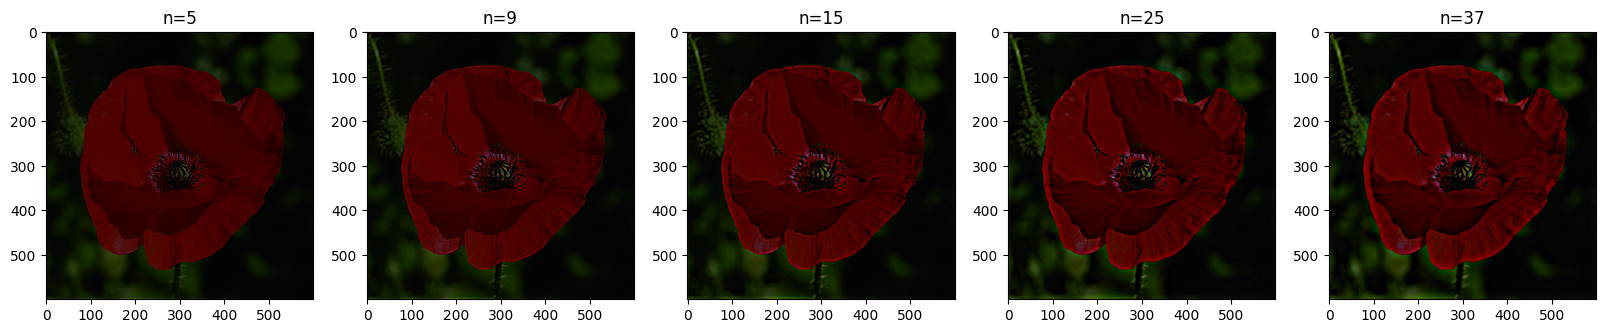

In [ ]:
img_path = '../ppm_images/mine/flower.ppm'
img = read_ppm(img_path)

images = []
titles = []

for n in [5, 9, 15, 25, 37]:
    identity_kernel = get_identity_kernel(n)
    gauss_kernel = get_gaussian_kernel(n, sigma=10)

    highpass_kernel = identity_kernel - gauss_kernel
    filtered = apply_filter(img, n, highpass_kernel)
    images.append(filtered)
    titles.append(f'n={n}')
    save_ppm(filtered, f'filtered_{n}.ppm', '../output')

fig, axes = plt.subplots(1, len(images), figsize=(20, 8))

for ax, img, title in zip(axes, images, titles):
    ax.imshow(img)
    ax.set_title(title)

In [41]:
# Show filtered
fi = Image.fromarray(filtered)
fi.show()



In [ ]:
# Show Original
with Image.open(img_path, 'r') as img:
    img.show()